In [1]:
import os
import random
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [ ]:
import gdown
from pathlib import Path  
url = 'https://drive.google.com/u/0/uc?id=1DyN5mk6oMqULPQ4z52KldztKHMl_ukW6&export=download&confirm=t&uuid=d2595c84-06e2-416e-ba3d-734be21e2664&at=AKKF8vwWd5qmBZcNqmu1E9Un_Xsu:1684169207246'
output = f'{Path().absolute()}/data.zip'
gdown.download(url, output, quiet = False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1DyN5mk6oMqULPQ4z52KldztKHMl_ukW6&export=download&confirm=t&uuid=d2595c84-06e2-416e-ba3d-734be21e2664&at=AKKF8vwWd5qmBZcNqmu1E9Un_Xsu:1684169207246
To: /content/data.zip
100%|██████████| 74.6M/74.6M [00:04<00:00, 18.2MB/s]


'/content/data.zip'

In [ ]:
import zipfile
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
import imagehash
import glob

hashes = {}
duplicated = []   

# Define a function to compute the hash of an image file
def compute_hash(filepath):
    with Image.open(filepath) as img:
        return str(imagehash.phash(img))
    
# Define a function to find and remove duplicated images
def check_duplicates(rootdir):
    rootdir = glob.glob(rootdir)
    duplicated = []
    max_length = 0
    for folder in rootdir:
        print()
        print(folder)
        for image_dir in glob.glob(folder+'/*.jpg'):
            # Compute the hash of the image file
            file_hash = compute_hash(image_dir)
            # Check if this hash has already been seen
            file=os.path.basename(image_dir).split('/')[-1]
            if file_hash in hashes:
                # if the image hash exists already, save the collision filenames
                dupe_idx = hashes[file_hash]
                duplicated.append((dupe_idx, image_dir))
            else:
                # This file is not a duplicate, so remember its hash
                hashes[file_hash] = image_dir
        print(r'Duplicated image in ',folder,' :',len(duplicated)-max_length)
        max_length=len(duplicated)

# Define a function to find and remove duplicated images
def remove_duplicates(rootdir):
    rootdir = glob.glob(rootdir)
    print(hashes)
    for folder in rootdir:
        print()
        print(folder)
        for image_dir in glob.glob(folder+'/*.jpg'):
            # Compute the hash of the image file
            file_hash = compute_hash(image_dir)
            # Check if this hash has already been seen
            file=os.path.basename(image_dir).split('/')[-1]
            if image_dir not in hashes.values():
                print(file_hash)
                print(image_dir)
                os.remove(image_dir)
                print(f'Removed duplicate file: {file}')

In [4]:
check_duplicates('data/Flowers/*')


data/Flowers\Babi
Duplicated image in  data/Flowers\Babi  : 41

data/Flowers\Calimerio
Duplicated image in  data/Flowers\Calimerio  : 41

data/Flowers\Chrysanthemum
Duplicated image in  data/Flowers\Chrysanthemum  : 26

data/Flowers\Hydrangeas
Duplicated image in  data/Flowers\Hydrangeas  : 18

data/Flowers\Lisianthus
Duplicated image in  data/Flowers\Lisianthus  : 133

data/Flowers\Pingpong
Duplicated image in  data/Flowers\Pingpong  : 20

data/Flowers\Rosy
Duplicated image in  data/Flowers\Rosy  : 19

data/Flowers\Tana
Duplicated image in  data/Flowers\Tana  : 135


In [5]:
remove_duplicates('data/Flowers/*')

{'c7174a592f613734': 'data/Flowers\\Babi\\babi_1.jpg', 'c89f2c643c6a97b1': 'data/Flowers\\Babi\\babi_10.jpg', 'd0ef5b06297c1927': 'data/Flowers\\Babi\\babi_100.jpg', 'b9acd27987d3a031': 'data/Flowers\\Babi\\babi_101.jpg', '80bb625f312d3f91': 'data/Flowers\\Babi\\babi_102.jpg', 'a7ddd024cacb8734': 'data/Flowers\\Babi\\babi_103.jpg', '81285a1579fe36f1': 'data/Flowers\\Babi\\babi_104.jpg', '9677385e2b41af60': 'data/Flowers\\Babi\\babi_105.jpg', 'b234162dbdd6c652': 'data/Flowers\\Babi\\babi_106.jpg', '88b22f0f733d8e70': 'data/Flowers\\Babi\\babi_107.jpg', 'b0ca6f2d487665c9': 'data/Flowers\\Babi\\babi_108.jpg', 'd6861e5a61948fb3': 'data/Flowers\\Babi\\babi_109.jpg', 'add284d9169c698f': 'data/Flowers\\Babi\\babi_11.jpg', 'b699075a3a6a71f0': 'data/Flowers\\Babi\\babi_110.jpg', '95830f4a64f8e59b': 'data/Flowers\\Babi\\babi_111.jpg', 'ec31c5c19b3e294b': 'data/Flowers\\Babi\\babi_112.jpg', 'bad78dd269852a52': 'data/Flowers\\Babi\\babi_113.jpg', '90c7590f6e792c0f': 'data/Flowers\\Babi\\babi_114.j

In [2]:
def recall_cnn(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_cnn(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_cnn(y_true, y_pred):
    precision = precision_cnn(y_true, y_pred)
    recall = recall_cnn(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [3]:
METRICS = ["accuracy", recall_cnn, precision_cnn, f1_cnn]

In [4]:
def visualize_history(history):
    #  "Plot Accuracy"
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

    # "Plot Loss"
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


In [5]:
def train_model(epochs_num, model, train_iter, valid_iter, export_dir="./export", name="default"):
    # -------------------------------------------------------------------------
    #                        Train CNN Model
    # -------------------------------------------------------------------------

    epochs = epochs_num

    callbacks = [EarlyStopping(monitor='val_accuracy', patience=7, mode='max', verbose=1)]

    history = model.fit(
        train_iter,
        steps_per_epoch=len(train_iter),
        validation_data=valid_iter,
        validation_steps=len(valid_iter),
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
    )

    return history

In [6]:
VGG16_model = Sequential()
VGG16_model.add(Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=(224, 224, 3)))
VGG16_model.add(MaxPooling2D(pool_size=(2,2)))
VGG16_model.add(Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'))
VGG16_model.add(MaxPooling2D(pool_size=(2,2)))
VGG16_model.add(Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'))
VGG16_model.add(MaxPooling2D(pool_size=(2,2)))
VGG16_model.add(Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'))
VGG16_model.add(MaxPooling2D(pool_size=(2,2)))
VGG16_model.add(Flatten())

VGG16_model.add(Dense(128, activation='relu'))
VGG16_model.add(Dense(64, activation='relu'))
VGG16_model.add(Dense(8, activation='softmax'))

In [7]:
VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [10]:
data_folder = 'data/Flowers'

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    validation_split=0.2  # 20% of the data will be used for validation
)

train_generator = train_datagen.flow_from_directory(
    data_folder,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'  # Use the training subset
)

validation_generator = train_datagen.flow_from_directory(
    data_folder,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='validation'  # Use the validation subset
)

Found 3352 images belonging to 8 classes.
Found 836 images belonging to 8 classes.


In [13]:
%%time

VGG16_model.compile(loss='categorical_crossentropy',
                       optimizer="Adam", metrics=METRICS)

CPU times: total: 0 ns
Wall time: 12.2 ms


In [15]:
history_vgg16 = train_model(70, VGG16_model, train_generator, validation_generator, export_dir="./export", name="vgg16")
history_vgg16

Epoch 1/70


KeyboardInterrupt: 

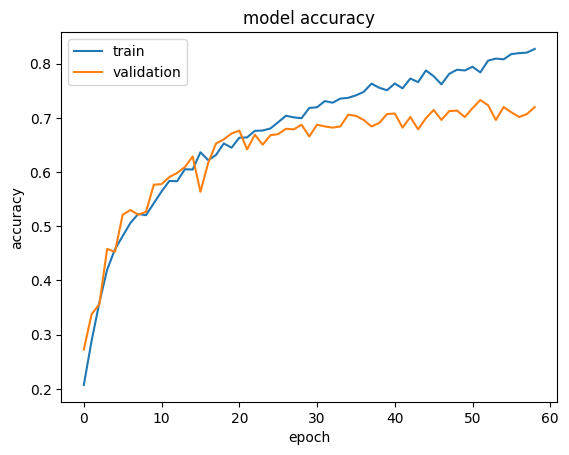

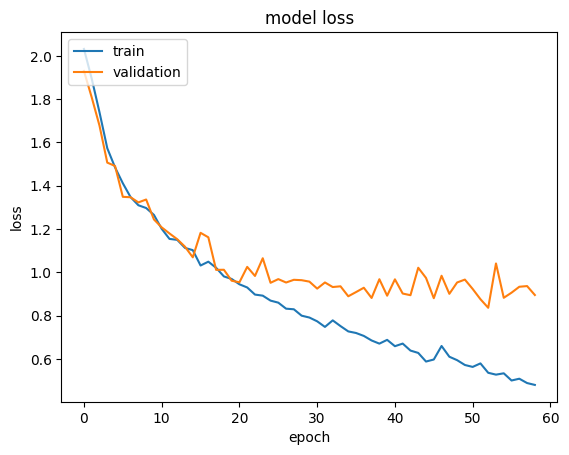

In [ ]:
visualize_history(history_vgg16)

In [ ]:
def display_images(image_path, input_image, similar_images):
    num_similar_images = len(similar_images)
    num_output_rows = num_similar_images
    num_output_cols = 1
    row_height = 3
    padding = 0.5

    # Create a figure with a grid for input and similar images
    fig, axes = plt.subplots(num_output_rows + 1, num_output_cols, figsize=(12, 2 + (num_output_rows + 1) * row_height))
    fig.suptitle("Similar Images", fontsize=14, fontweight='bold')

    # Display the input image
    axes[0, 0].imshow(input_image)
    axes[0, 0].set_title("Input Image\n" + os.path.basename(image_path))
    axes[0, 0].axis('off')

    # Display the similar images
    for i, (image_path, flower_type, similarity) in enumerate(similar_images):
        img_similar = Image.open(image_path)
        row = i + 1
        col = 0
        axes[row, col].imshow(img_similar)
        axes[row, col].set_title(f"Similar Image {i+1}\n{os.path.basename(image_path)}\nFlower Type: {flower_type}\nSimilarity: {similarity:.2f}")
        axes[row, col].axis('off')

    # Adjust spacing between rows
    fig.subplots_adjust(hspace=padding)

    # Remove empty subplots
    for i in range(num_similar_images + 1, num_output_rows * num_output_cols):
        row = i // num_output_cols
        col = i % num_output_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

In [ ]:
def find_similar_images(model, image_path):
    data_folder = os.path.dirname(os.path.dirname(image_path))
    flower_types = os.listdir(data_folder)
    top_n = 10

    # Load and preprocess the input image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.vgg16.preprocess_input(x)

    # Create a new model that outputs the desired layer's activations
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('flatten').output)

    # Extract the feature vector of the input image
    features = intermediate_layer_model.predict(x)

    # Calculate cosine similarities between the input image and all the images in the dataset
    similarities = []
    for i, flower_type in enumerate(flower_types):
        folder_path = os.path.join(data_folder, flower_type)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.jpg'):
                image_path_i = os.path.join(folder_path, file_name)
                if image_path_i == image_path:
                    continue  # Skip the comparison if the image paths are the same
                img_i = tf.keras.preprocessing.image.load_img(image_path_i, target_size=(224, 224))
                x_i = tf.keras.preprocessing.image.img_to_array(img_i)
                x_i = np.expand_dims(x_i, axis=0)
                x_i = tf.keras.applications.vgg16.preprocess_input(x_i)
                features_i = intermediate_layer_model.predict(x_i)

                # Ensure that the features belong to the same class
                if flower_type == os.path.basename(os.path.dirname(image_path_i)):
                    similarity = cosine_similarity(features, features_i)[0][0]
                    similarities.append((image_path_i, flower_type, similarity))

    # Sort the similarities in descending order and select the top_n images
    similarities = sorted(similarities, key=lambda x: x[2], reverse=True)[:top_n]

    # Display the input image, filename, and flower type
    print("Input Image:", os.path.basename(image_path))

    # Extract the input image for display
    input_image = Image.open(image_path)

    # Extract the similar images for display
    similar_images = []
    for image_path, flower_type, similarity in similarities:
        similar_images.append((image_path, flower_type, similarity))

    # Call the display_images function to show the input image and similar images
    display_images(image_path, input_image, similar_images)


In [ ]:
find_similar_images(VGG16_model, "data/Flowers/Babi/babi_1.jpg")

NameError: ignored

AlexNet

In [11]:
def AlexNet(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(96, kernel_size=(11, 11), strides=4, padding='valid', activation='relu', input_shape=input_shape, kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', data_format=None))

    model.add(Conv2D(256, kernel_size=(5, 5), strides=1, padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', data_format=None))

    model.add(Conv2D(384, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal'))

    model.add(Conv2D(384, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal'))

    model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal'))

    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', data_format=None))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [12]:
# https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide
input_shape = (224, 224, 3)
num_classes = 8

AlexNet_model = AlexNet(input_shape, num_classes)

In [13]:
AlexNet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 384)      

In [14]:
%%time

AlexNet_model.compile(loss='binary_crossentropy',
                       optimizer="Adam", metrics=METRICS)

NameError: name 'model_Alexnet' is not defined

In [ ]:
history_alexnet = train_model(
    70, model_Alexnet, train_generator, validation_generator, export_dir="./export", name="alexnet"
)

In [ ]:
visualize_history(history_alexnet)